In [2]:
# ✅ 0. CSV 로딩 및 전처리 (하루 총 발전량 예측용: scalar target)
import pandas as pd
import numpy as np

# 전체 컬럼 로딩
df = pd.read_csv("df_solar_final_sorted.csv")

# 그룹화 및 일 단위 데이터 수집
dynamic_x_list, static_x_list, labels_list = [], [], []

for plant, group in df.groupby('발전구분'):
    group = group.sort_values(by=['year', 'month', 'day', 'hour'])
    for (y, m, d), day_data in group.groupby(['year', 'month', 'day']):
        if len(day_data) != 24:
            continue
        if day_data['일사(MJ/m2)'].sum() == 0:
            continue  # ✅ 야간 제거
        day_data = day_data.sort_values('hour')

        dyn = day_data[[
            '일사(MJ/m2)', '태양고도', '기온(°C)', '풍속(m/s)', 
            '하늘상태', '습도(%)', '강수량(mm)'
        ]].values
        dynamic_x_list.append(dyn)

        static = [
            day_data.iloc[0]['설비용량(MW)'],
            day_data.iloc[0]['연식(년)'],
            day_data.iloc[0]['month'],
            day_data.iloc[0]['weekday']
        ]
        static_x_list.append(static)

        labels_list.append(np.log1p(day_data['발전량(kWh)'].sum()))  # ✅ 하루 총합으로 변경

# numpy 변환 및 NaN 제거
dynamic_x = np.stack(dynamic_x_list)
static_x = np.stack(static_x_list)
labels = np.array(labels_list).reshape(-1, 1)  # ✅ shape: (N, 1)

mask = (
    ~np.isnan(dynamic_x).any(axis=(1, 2)) &
    ~np.isnan(static_x).any(axis=1) &
    ~np.isnan(labels).any(axis=1)
)

dynamic_x = dynamic_x[mask]
static_x = static_x[mask]
labels = labels[mask]

In [3]:
# ✅ 1. 라이브러리
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()

# ✅ 2. Transformer
class SolarForecastTransformer(nn.Module):
    def __init__(self, input_dim, model_dim=128, num_heads=4, num_layers=2, dropout=0.1, output_dim=1):
        super().__init__()
        self.input_projection = nn.Linear(input_dim, model_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.static_projection = nn.Linear(4, model_dim)
        self.output_layer = nn.Linear(model_dim, output_dim)

    def forward(self, dynamic_x, static_x):
        x = self.input_projection(dynamic_x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        static_emb = self.static_projection(static_x)
        fused = x + static_emb
        return self.output_layer(fused)

# ✅ 3. Dataset
class SolarDataset(Dataset):
    def __init__(self, dynamic_x, static_x, y):
        self.dynamic_x = torch.tensor(dynamic_x, dtype=torch.float32)
        self.static_x = torch.tensor(static_x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.dynamic_x[idx], self.static_x[idx], self.y[idx]

# ✅ 4. 학습 및 평가

def train_model(model, dataloader, optimizer, criterion, epoch, total_epochs, repeat, total_repeats):
    model.train()
    total_loss = 0
    for dynamic_x, static_x, y in dataloader:
        optimizer.zero_grad()
        outputs = model(dynamic_x, static_x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[Repeat {repeat}/{total_repeats}] Epoch {epoch}/{total_epochs} - Loss: {total_loss / len(dataloader):.4f}")


def evaluate_model(model, dataloader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for dynamic_x, static_x, y in dataloader:
            outputs = model(dynamic_x, static_x)
            preds.append(outputs.numpy())
            trues.append(y.numpy())
    preds = np.expm1(np.vstack(preds))  # ✅ 로그 복원
    trues = np.expm1(np.vstack(trues))
    mae = mean_absolute_error(trues, preds)
    rmse = mean_squared_error(trues, preds, squared=False)
    r2 = r2_score(trues, preds)
    mean_true = np.mean(trues)
    rmse_ratio = (rmse / mean_true) * 100
    print(f"RMSE Ratio: {rmse_ratio:.2f}%")
    return mae, rmse, r2, preds, trues

# ✅ 5. 실행

def run_experiment(dynamic_x, static_x, y):
    X_train, X_test, s_train, s_test, y_train, y_test = train_test_split(dynamic_x, static_x, y, test_size=0.2, random_state=42)
    train_dataset = SolarDataset(X_train, s_train, y_train)
    test_dataset = SolarDataset(X_test, s_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    best_rmse = float('inf')
    best_model = None

    n_repeat = 3
    for repeat in range(1, n_repeat + 1):
        for model_dim in [64, 128]:
            for lr in [1e-3, 5e-4]:
                print(f"\n▶ Repeat {repeat}/{n_repeat} | model_dim={model_dim}, lr={lr}")
                model = SolarForecastTransformer(input_dim=X_train.shape[2], model_dim=model_dim)
                optimizer = optim.Adam(model.parameters(), lr=lr)
                criterion = nn.MSELoss()
                total_epochs = 30
                for epoch in range(1, total_epochs + 1):
                    train_model(model, train_loader, optimizer, criterion, epoch, total_epochs, repeat, n_repeat)
                mae, rmse, r2, _, _ = evaluate_model(model, test_loader)
                print(f"Evaluation → MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}")
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_model = model

    return best_model, test_loader

# ✅ 6. 시각화

def plot_sample_prediction(model, test_loader, index=0):
    model.eval()
    all_data = list(test_loader)
    dx, sx, y_true = all_data[index]
    with torch.no_grad():
        pred = model(dx, sx).numpy()
        true = y_true.numpy()
    pred = np.expm1(pred.flatten())
    true = np.expm1(true.flatten())
    plt.figure(figsize=(8, 4))
    plt.bar(["Actual"], true, color='skyblue')
    plt.bar(["Predicted"], pred, color='orange')
    plt.title(f"Sample {index} - 하루 총 발전량 예측 (kWh)")
    plt.ylabel("kWh")
    plt.grid(True, axis='y')
    plt.show()


▶ Repeat 1/3 | model_dim=64, lr=0.001
[Repeat 1/3] Epoch 1/30 - Loss: 6.0524
[Repeat 1/3] Epoch 2/30 - Loss: 2.4157
[Repeat 1/3] Epoch 3/30 - Loss: 2.0293
[Repeat 1/3] Epoch 4/30 - Loss: 1.8291
[Repeat 1/3] Epoch 5/30 - Loss: 1.7316
[Repeat 1/3] Epoch 6/30 - Loss: 1.6834
[Repeat 1/3] Epoch 7/30 - Loss: 1.6717
[Repeat 1/3] Epoch 8/30 - Loss: 1.6427
[Repeat 1/3] Epoch 9/30 - Loss: 1.6669
[Repeat 1/3] Epoch 10/30 - Loss: 1.6690
[Repeat 1/3] Epoch 11/30 - Loss: 1.6525
[Repeat 1/3] Epoch 12/30 - Loss: 1.7102
[Repeat 1/3] Epoch 13/30 - Loss: 1.6360
[Repeat 1/3] Epoch 14/30 - Loss: 1.6565
[Repeat 1/3] Epoch 15/30 - Loss: 1.6137
[Repeat 1/3] Epoch 16/30 - Loss: 1.6122
[Repeat 1/3] Epoch 17/30 - Loss: 1.5895
[Repeat 1/3] Epoch 18/30 - Loss: 1.6180
[Repeat 1/3] Epoch 19/30 - Loss: 1.6138
[Repeat 1/3] Epoch 20/30 - Loss: 1.6328
[Repeat 1/3] Epoch 21/30 - Loss: 1.5975
[Repeat 1/3] Epoch 22/30 - Loss: 1.6061
[Repeat 1/3] Epoch 23/30 - Loss: 1.6065
[Repeat 1/3] Epoch 24/30 - Loss: 1.5936
[Repeat 1/

c:\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE Ratio: 54.32%
Evaluation → MAE: 4900.253, RMSE: 9434.881, R²: 0.830

▶ Repeat 1/3 | model_dim=64, lr=0.0005
[Repeat 1/3] Epoch 1/30 - Loss: 6.4197
[Repeat 1/3] Epoch 2/30 - Loss: 2.5338
[Repeat 1/3] Epoch 3/30 - Loss: 2.2055
[Repeat 1/3] Epoch 4/30 - Loss: 1.9949
[Repeat 1/3] Epoch 5/30 - Loss: 1.8960
[Repeat 1/3] Epoch 6/30 - Loss: 1.7864
[Repeat 1/3] Epoch 7/30 - Loss: 1.7153
[Repeat 1/3] Epoch 8/30 - Loss: 1.6800
[Repeat 1/3] Epoch 9/30 - Loss: 1.6707
[Repeat 1/3] Epoch 10/30 - Loss: 1.6417
[Repeat 1/3] Epoch 11/30 - Loss: 1.6315
[Repeat 1/3] Epoch 12/30 - Loss: 1.6084
[Repeat 1/3] Epoch 13/30 - Loss: 1.6144
[Repeat 1/3] Epoch 14/30 - Loss: 1.6125
[Repeat 1/3] Epoch 15/30 - Loss: 1.5982
[Repeat 1/3] Epoch 16/30 - Loss: 1.6169
[Repeat 1/3] Epoch 17/30 - Loss: 1.5784
[Repeat 1/3] Epoch 18/30 - Loss: 1.5892
[Repeat 1/3] Epoch 19/30 - Loss: 1.5689
[Repeat 1/3] Epoch 20/30 - Loss: 1.6145
[Repeat 1/3] Epoch 21/30 - Loss: 1.5901
[Repeat 1/3] Epoch 22/30 - Loss: 1.5810
[Repeat 1/3] Epo

c:\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE Ratio: 43.34%
Evaluation → MAE: 3804.174, RMSE: 7526.921, R²: 0.892

▶ Repeat 1/3 | model_dim=128, lr=0.001
[Repeat 1/3] Epoch 1/30 - Loss: 2.7583
[Repeat 1/3] Epoch 2/30 - Loss: 1.9130
[Repeat 1/3] Epoch 3/30 - Loss: 1.7628
[Repeat 1/3] Epoch 4/30 - Loss: 1.7360
[Repeat 1/3] Epoch 5/30 - Loss: 1.7498
[Repeat 1/3] Epoch 6/30 - Loss: 1.7011
[Repeat 1/3] Epoch 7/30 - Loss: 1.7362
[Repeat 1/3] Epoch 8/30 - Loss: 1.7261
[Repeat 1/3] Epoch 9/30 - Loss: 1.6797
[Repeat 1/3] Epoch 10/30 - Loss: 1.7589
[Repeat 1/3] Epoch 11/30 - Loss: 1.6967
[Repeat 1/3] Epoch 12/30 - Loss: 1.6650
[Repeat 1/3] Epoch 13/30 - Loss: 1.6970
[Repeat 1/3] Epoch 14/30 - Loss: 1.6560
[Repeat 1/3] Epoch 15/30 - Loss: 1.6602
[Repeat 1/3] Epoch 16/30 - Loss: 1.6524
[Repeat 1/3] Epoch 17/30 - Loss: 1.6257
[Repeat 1/3] Epoch 18/30 - Loss: 1.7522
[Repeat 1/3] Epoch 19/30 - Loss: 1.6761
[Repeat 1/3] Epoch 20/30 - Loss: 1.6570
[Repeat 1/3] Epoch 21/30 - Loss: 1.6511
[Repeat 1/3] Epoch 22/30 - Loss: 1.6184
[Repeat 1/3] Epo

c:\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE Ratio: 63.44%
Evaluation → MAE: 5389.876, RMSE: 11018.829, R²: 0.768

▶ Repeat 1/3 | model_dim=128, lr=0.0005
[Repeat 1/3] Epoch 1/30 - Loss: 4.7465
[Repeat 1/3] Epoch 2/30 - Loss: 2.2172
[Repeat 1/3] Epoch 3/30 - Loss: 1.9223
[Repeat 1/3] Epoch 4/30 - Loss: 1.8470
[Repeat 1/3] Epoch 5/30 - Loss: 1.7665
[Repeat 1/3] Epoch 6/30 - Loss: 1.7488
[Repeat 1/3] Epoch 7/30 - Loss: 1.7162
[Repeat 1/3] Epoch 8/30 - Loss: 1.7122
[Repeat 1/3] Epoch 9/30 - Loss: 1.6781
[Repeat 1/3] Epoch 10/30 - Loss: 1.6854
[Repeat 1/3] Epoch 11/30 - Loss: 1.6923
[Repeat 1/3] Epoch 12/30 - Loss: 1.6831
[Repeat 1/3] Epoch 13/30 - Loss: 1.6678
[Repeat 1/3] Epoch 14/30 - Loss: 1.6490
[Repeat 1/3] Epoch 15/30 - Loss: 1.6398
[Repeat 1/3] Epoch 16/30 - Loss: 1.6539
[Repeat 1/3] Epoch 17/30 - Loss: 1.6428
[Repeat 1/3] Epoch 18/30 - Loss: 1.6275
[Repeat 1/3] Epoch 19/30 - Loss: 1.6360
[Repeat 1/3] Epoch 20/30 - Loss: 1.6502
[Repeat 1/3] Epoch 21/30 - Loss: 1.6150
[Repeat 1/3] Epoch 22/30 - Loss: 1.6326
[Repeat 1/3] E

c:\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE Ratio: 44.22%
Evaluation → MAE: 4051.474, RMSE: 7680.720, R²: 0.887

▶ Repeat 2/3 | model_dim=64, lr=0.001
[Repeat 2/3] Epoch 1/30 - Loss: 4.0719
[Repeat 2/3] Epoch 2/30 - Loss: 2.2837
[Repeat 2/3] Epoch 3/30 - Loss: 1.8802
[Repeat 2/3] Epoch 4/30 - Loss: 1.7407
[Repeat 2/3] Epoch 5/30 - Loss: 1.7232
[Repeat 2/3] Epoch 6/30 - Loss: 1.7491
[Repeat 2/3] Epoch 7/30 - Loss: 1.6807
[Repeat 2/3] Epoch 8/30 - Loss: 1.6591
[Repeat 2/3] Epoch 9/30 - Loss: 1.6447
[Repeat 2/3] Epoch 10/30 - Loss: 1.6514
[Repeat 2/3] Epoch 11/30 - Loss: 1.6425
[Repeat 2/3] Epoch 12/30 - Loss: 1.6457
[Repeat 2/3] Epoch 13/30 - Loss: 1.6504
[Repeat 2/3] Epoch 14/30 - Loss: 1.6295
[Repeat 2/3] Epoch 15/30 - Loss: 1.5979
[Repeat 2/3] Epoch 16/30 - Loss: 1.5955
[Repeat 2/3] Epoch 17/30 - Loss: 1.6316
[Repeat 2/3] Epoch 18/30 - Loss: 1.6053
[Repeat 2/3] Epoch 19/30 - Loss: 1.5977
[Repeat 2/3] Epoch 20/30 - Loss: 1.6029
[Repeat 2/3] Epoch 21/30 - Loss: 1.5955
[Repeat 2/3] Epoch 22/30 - Loss: 1.6364
[Repeat 2/3] Epoc

c:\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE Ratio: 92.15%
Evaluation → MAE: 9208.420, RMSE: 16005.910, R²: 0.510

▶ Repeat 2/3 | model_dim=64, lr=0.0005
[Repeat 2/3] Epoch 1/30 - Loss: 5.3221
[Repeat 2/3] Epoch 2/30 - Loss: 2.5403
[Repeat 2/3] Epoch 3/30 - Loss: 2.1960
[Repeat 2/3] Epoch 4/30 - Loss: 1.9771
[Repeat 2/3] Epoch 5/30 - Loss: 1.8673
[Repeat 2/3] Epoch 6/30 - Loss: 1.7690
[Repeat 2/3] Epoch 7/30 - Loss: 1.7177
[Repeat 2/3] Epoch 8/30 - Loss: 1.7012
[Repeat 2/3] Epoch 9/30 - Loss: 1.7246
[Repeat 2/3] Epoch 10/30 - Loss: 1.6777
[Repeat 2/3] Epoch 11/30 - Loss: 1.6649
[Repeat 2/3] Epoch 12/30 - Loss: 1.6499
[Repeat 2/3] Epoch 13/30 - Loss: 1.6557
[Repeat 2/3] Epoch 14/30 - Loss: 1.6413
[Repeat 2/3] Epoch 15/30 - Loss: 1.6384
[Repeat 2/3] Epoch 16/30 - Loss: 1.6338
[Repeat 2/3] Epoch 17/30 - Loss: 1.6088
[Repeat 2/3] Epoch 18/30 - Loss: 1.6060
[Repeat 2/3] Epoch 19/30 - Loss: 1.6322
[Repeat 2/3] Epoch 20/30 - Loss: 1.6188
[Repeat 2/3] Epoch 21/30 - Loss: 1.6029
[Repeat 2/3] Epoch 22/30 - Loss: 1.6229
[Repeat 2/3] Ep

c:\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE Ratio: 38.43%
Evaluation → MAE: 3516.763, RMSE: 6675.601, R²: 0.915

▶ Repeat 2/3 | model_dim=128, lr=0.001
[Repeat 2/3] Epoch 1/30 - Loss: 2.6242
[Repeat 2/3] Epoch 2/30 - Loss: 1.8673
[Repeat 2/3] Epoch 3/30 - Loss: 1.7577
[Repeat 2/3] Epoch 4/30 - Loss: 1.7204
[Repeat 2/3] Epoch 5/30 - Loss: 1.7539
[Repeat 2/3] Epoch 6/30 - Loss: 1.7114
[Repeat 2/3] Epoch 7/30 - Loss: 1.7081
[Repeat 2/3] Epoch 8/30 - Loss: 1.6850
[Repeat 2/3] Epoch 9/30 - Loss: 1.7263
[Repeat 2/3] Epoch 10/30 - Loss: 1.7053
[Repeat 2/3] Epoch 11/30 - Loss: 1.6963
[Repeat 2/3] Epoch 12/30 - Loss: 1.6653
[Repeat 2/3] Epoch 13/30 - Loss: 1.6751
[Repeat 2/3] Epoch 14/30 - Loss: 1.6121
[Repeat 2/3] Epoch 15/30 - Loss: 1.6797
[Repeat 2/3] Epoch 16/30 - Loss: 1.6717
[Repeat 2/3] Epoch 17/30 - Loss: 1.6326
[Repeat 2/3] Epoch 18/30 - Loss: 1.5929
[Repeat 2/3] Epoch 19/30 - Loss: 1.6414
[Repeat 2/3] Epoch 20/30 - Loss: 1.6495
[Repeat 2/3] Epoch 21/30 - Loss: 1.6422
[Repeat 2/3] Epoch 22/30 - Loss: 1.6136
[Repeat 2/3] Epo

c:\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE Ratio: 44.36%
Evaluation → MAE: 4108.686, RMSE: 7704.106, R²: 0.886

▶ Repeat 2/3 | model_dim=128, lr=0.0005
[Repeat 2/3] Epoch 1/30 - Loss: 2.7604
[Repeat 2/3] Epoch 2/30 - Loss: 1.8990
[Repeat 2/3] Epoch 3/30 - Loss: 1.7616
[Repeat 2/3] Epoch 4/30 - Loss: 1.7383
[Repeat 2/3] Epoch 5/30 - Loss: 1.6995
[Repeat 2/3] Epoch 6/30 - Loss: 1.7032
[Repeat 2/3] Epoch 7/30 - Loss: 1.6651
[Repeat 2/3] Epoch 8/30 - Loss: 1.6598
[Repeat 2/3] Epoch 9/30 - Loss: 1.6874
[Repeat 2/3] Epoch 10/30 - Loss: 1.6708
[Repeat 2/3] Epoch 11/30 - Loss: 1.6117
[Repeat 2/3] Epoch 12/30 - Loss: 1.6276
[Repeat 2/3] Epoch 13/30 - Loss: 1.6516
[Repeat 2/3] Epoch 14/30 - Loss: 1.6223
[Repeat 2/3] Epoch 15/30 - Loss: 1.6324
[Repeat 2/3] Epoch 16/30 - Loss: 1.6288
[Repeat 2/3] Epoch 17/30 - Loss: 1.6189
[Repeat 2/3] Epoch 18/30 - Loss: 1.5994
[Repeat 2/3] Epoch 19/30 - Loss: 1.5875
[Repeat 2/3] Epoch 20/30 - Loss: 1.6390
[Repeat 2/3] Epoch 21/30 - Loss: 1.6070
[Repeat 2/3] Epoch 22/30 - Loss: 1.6040
[Repeat 2/3] Ep

c:\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE Ratio: 70.12%
Evaluation → MAE: 6003.642, RMSE: 12179.074, R²: 0.716

▶ Repeat 3/3 | model_dim=64, lr=0.001
[Repeat 3/3] Epoch 1/30 - Loss: 5.5374
[Repeat 3/3] Epoch 2/30 - Loss: 2.5407
[Repeat 3/3] Epoch 3/30 - Loss: 2.1340
[Repeat 3/3] Epoch 4/30 - Loss: 1.8591
[Repeat 3/3] Epoch 5/30 - Loss: 1.7575
[Repeat 3/3] Epoch 6/30 - Loss: 1.7241
[Repeat 3/3] Epoch 7/30 - Loss: 1.7073
[Repeat 3/3] Epoch 8/30 - Loss: 1.7071
[Repeat 3/3] Epoch 9/30 - Loss: 1.6826
[Repeat 3/3] Epoch 10/30 - Loss: 1.6676
[Repeat 3/3] Epoch 11/30 - Loss: 1.6565
[Repeat 3/3] Epoch 12/30 - Loss: 1.6687
[Repeat 3/3] Epoch 13/30 - Loss: 1.6525
[Repeat 3/3] Epoch 14/30 - Loss: 1.6385
[Repeat 3/3] Epoch 15/30 - Loss: 1.6194
[Repeat 3/3] Epoch 16/30 - Loss: 1.6228
[Repeat 3/3] Epoch 17/30 - Loss: 1.6224
[Repeat 3/3] Epoch 18/30 - Loss: 1.6209
[Repeat 3/3] Epoch 19/30 - Loss: 1.6160
[Repeat 3/3] Epoch 20/30 - Loss: 1.6273
[Repeat 3/3] Epoch 21/30 - Loss: 1.6054
[Repeat 3/3] Epoch 22/30 - Loss: 1.5774
[Repeat 3/3] Epo

c:\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE Ratio: 131.89%
Evaluation → MAE: 11846.706, RMSE: 22907.512, R²: -0.004

▶ Repeat 3/3 | model_dim=64, lr=0.0005
[Repeat 3/3] Epoch 1/30 - Loss: 4.9942
[Repeat 3/3] Epoch 2/30 - Loss: 2.6318
[Repeat 3/3] Epoch 3/30 - Loss: 2.3097
[Repeat 3/3] Epoch 4/30 - Loss: 2.0627
[Repeat 3/3] Epoch 5/30 - Loss: 1.8520
[Repeat 3/3] Epoch 6/30 - Loss: 1.8074
[Repeat 3/3] Epoch 7/30 - Loss: 1.7286
[Repeat 3/3] Epoch 8/30 - Loss: 1.6924
[Repeat 3/3] Epoch 9/30 - Loss: 1.7051
[Repeat 3/3] Epoch 10/30 - Loss: 1.6708
[Repeat 3/3] Epoch 11/30 - Loss: 1.6623
[Repeat 3/3] Epoch 12/30 - Loss: 1.6499
[Repeat 3/3] Epoch 13/30 - Loss: 1.6349
[Repeat 3/3] Epoch 14/30 - Loss: 1.6331
[Repeat 3/3] Epoch 15/30 - Loss: 1.6342
[Repeat 3/3] Epoch 16/30 - Loss: 1.6269
[Repeat 3/3] Epoch 17/30 - Loss: 1.6051
[Repeat 3/3] Epoch 18/30 - Loss: 1.6314
[Repeat 3/3] Epoch 19/30 - Loss: 1.6238
[Repeat 3/3] Epoch 20/30 - Loss: 1.6085
[Repeat 3/3] Epoch 21/30 - Loss: 1.6340
[Repeat 3/3] Epoch 22/30 - Loss: 1.5916
[Repeat 3/3]

c:\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE Ratio: 46.75%
Evaluation → MAE: 4556.688, RMSE: 8120.224, R²: 0.874

▶ Repeat 3/3 | model_dim=128, lr=0.001
[Repeat 3/3] Epoch 1/30 - Loss: 2.6051
[Repeat 3/3] Epoch 2/30 - Loss: 1.8428
[Repeat 3/3] Epoch 3/30 - Loss: 1.7986
[Repeat 3/3] Epoch 4/30 - Loss: 1.8147
[Repeat 3/3] Epoch 5/30 - Loss: 1.7039
[Repeat 3/3] Epoch 6/30 - Loss: 1.6873
[Repeat 3/3] Epoch 7/30 - Loss: 1.6871
[Repeat 3/3] Epoch 8/30 - Loss: 1.7185
[Repeat 3/3] Epoch 9/30 - Loss: 1.7241
[Repeat 3/3] Epoch 10/30 - Loss: 1.6573
[Repeat 3/3] Epoch 11/30 - Loss: 1.7185
[Repeat 3/3] Epoch 12/30 - Loss: 1.6567
[Repeat 3/3] Epoch 13/30 - Loss: 1.7011
[Repeat 3/3] Epoch 14/30 - Loss: 1.6355
[Repeat 3/3] Epoch 15/30 - Loss: 1.6265
[Repeat 3/3] Epoch 16/30 - Loss: 1.6247
[Repeat 3/3] Epoch 17/30 - Loss: 1.6453
[Repeat 3/3] Epoch 18/30 - Loss: 1.6016
[Repeat 3/3] Epoch 19/30 - Loss: 1.6553
[Repeat 3/3] Epoch 20/30 - Loss: 1.6474
[Repeat 3/3] Epoch 21/30 - Loss: 1.6189
[Repeat 3/3] Epoch 22/30 - Loss: 1.6301
[Repeat 3/3] Epo

c:\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE Ratio: 56.92%
Evaluation → MAE: 5315.019, RMSE: 9886.846, R²: 0.813

▶ Repeat 3/3 | model_dim=128, lr=0.0005
[Repeat 3/3] Epoch 1/30 - Loss: 6.1291
[Repeat 3/3] Epoch 2/30 - Loss: 2.2108
[Repeat 3/3] Epoch 3/30 - Loss: 2.0969
[Repeat 3/3] Epoch 4/30 - Loss: 1.8970
[Repeat 3/3] Epoch 5/30 - Loss: 1.8044
[Repeat 3/3] Epoch 6/30 - Loss: 1.7618
[Repeat 3/3] Epoch 7/30 - Loss: 1.7137
[Repeat 3/3] Epoch 8/30 - Loss: 1.7145
[Repeat 3/3] Epoch 9/30 - Loss: 1.6992
[Repeat 3/3] Epoch 10/30 - Loss: 1.7469
[Repeat 3/3] Epoch 11/30 - Loss: 1.6946
[Repeat 3/3] Epoch 12/30 - Loss: 1.7091
[Repeat 3/3] Epoch 13/30 - Loss: 1.6716
[Repeat 3/3] Epoch 14/30 - Loss: 1.7006
[Repeat 3/3] Epoch 15/30 - Loss: 1.6774
[Repeat 3/3] Epoch 16/30 - Loss: 1.7036
[Repeat 3/3] Epoch 17/30 - Loss: 1.6369
[Repeat 3/3] Epoch 18/30 - Loss: 1.6551
[Repeat 3/3] Epoch 19/30 - Loss: 1.6214
[Repeat 3/3] Epoch 20/30 - Loss: 1.6608
[Repeat 3/3] Epoch 21/30 - Loss: 1.6487
[Repeat 3/3] Epoch 22/30 - Loss: 1.6363
[Repeat 3/3] Ep

c:\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54616 (\N{HANGUL SYLLABLE HA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47336 (\N{HANGUL SYLLABLE RU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52509 (\N{HANGUL SYLLABLE CONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48156 (\N{HANGUL SYLLABLE BAL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\anaconda3\Lib\s

RMSE Ratio: 99.40%
Evaluation → MAE: 8281.272, RMSE: 17265.676, R²: 0.430


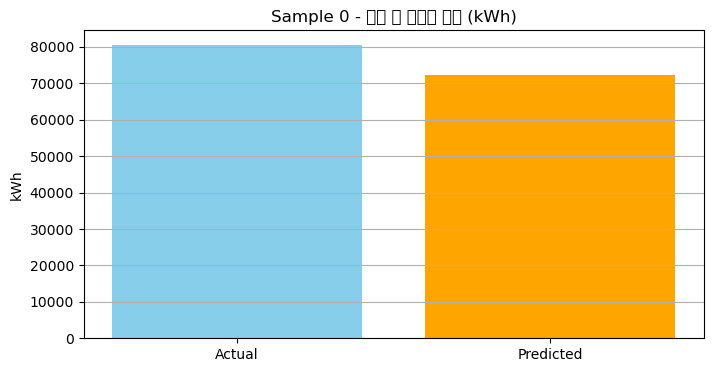

In [4]:
# ✅ 7. 실행
final_model, test_loader = run_experiment(dynamic_x, static_x, labels)
plot_sample_prediction(final_model, test_loader, index=0)